In [21]:
#!pip install graphviz
#!pip install pydot

In [22]:
import tensorflow.keras.layers as layers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from io import BytesIO

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

## 데이터 준비

In [23]:
#!pip install datasets
#!pip install huggingface_hub

### 데이터 로드

In [24]:
import datasets
from datasets import load_dataset
dataset = load_dataset("nateraw/pascal-voc-2012", split = "train")



### 데이터 확인

- 데이터 길이 및 모양
- 실제 이미지 데이터 확인
- 이미지 사이즈 및 채널 확인

In [25]:
print(dataset, dataset.shape, dataset[0]["image"])

Dataset({
    features: ['image', 'mask'],
    num_rows: 1464
}) (1464, 2) <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x281 at 0x7F86EC6908E0>


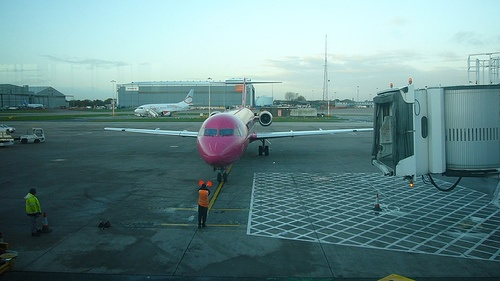

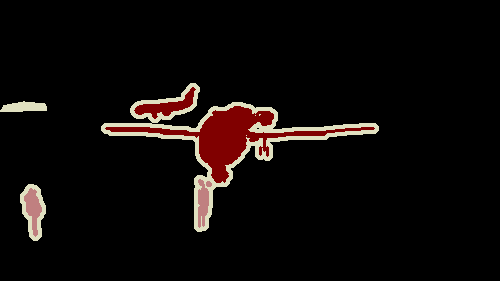

In [26]:
dataset[0]["image"].show()
dataset[0]["mask"].show()

### Unet 모델 구성

In [27]:
def UNet() :
    inputs = layers.Input(shape=(572, 572, 3))

    # Contracting path 시작
    conv0 = layers.Conv2D(64, activation='relu', kernel_size = 3)(inputs)
    conv1 = layers.Conv2D(64, activation='relu', kernel_size = 3)(conv0)  # Skip connection으로 Expanding path로 이어질 예정
    conv2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv1)


    conv3 = layers.Conv2D(128, activation='relu', kernel_size = 3)(conv2)
    conv4 = layers.Conv2D(128, activation='relu', kernel_size = 3)(conv3)
    conv5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv4)


    conv6 = layers.Conv2D(256, activation='relu', kernel_size = 3)(conv5)
    conv7 = layers.Conv2D(256, activation='relu', kernel_size = 3)(conv6)
    conv8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv7)


    conv9 = layers.Conv2D(512, activation='relu', kernel_size = 3)(conv8)
    conv10 = layers.Conv2D(512, activation="relu", kernel_size = 3)(conv9)
    conv11 = layers.MaxPool2D(pool_size=(2, 2), strides = (2, 2))(conv10)

    conv12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv11)
    conv13 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv12)
    # Contracting path 끝

    # Expanding path 시작
    trans01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(conv13)
    crop01 = layers.Cropping2D(cropping=(4, 4))(conv10) # 64 -> 56
    concat01 = layers.concatenate([trans01, crop01], axis=-1)

    conv14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
    conv15 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv14)

    trans02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(conv15) 
    crop02 = layers.Cropping2D(cropping=(16, 16))(conv7) # 136 -> 104 
    concat02 = layers.concatenate([trans02, crop02], axis=-1)

    conv16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
    conv17 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv16)

    trans03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(conv17) 
    crop03 = layers.Cropping2D(cropping=(40, 40))(conv4) # 280 -> 200 40
    concat03 = layers.concatenate([trans03, crop03], axis=-1)

    conv18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
    conv19 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv18)

    trans04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(conv19) 
    crop04 = layers.Cropping2D(cropping=(88, 88))(conv1) # 568 -> 392 = 176 88
    concat04 = layers.concatenate([trans04, crop04], axis=-1)

    conv20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
    conv21 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv20)

    output = layers.Conv2D(20, kernel_size=1, activation = "softmax")(conv21) 



    return Model(inputs = inputs, outputs=output)


In [28]:
model = UNet()
model.summary()
model.compile(
    optimizer = Adam(lr = 1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 572, 572, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 570, 570, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 568, 568, 64  36928       ['conv2d_38[0][0]']              
                                )                                                           

In [44]:
def preprocess_data(image, mask):
    # Normalize images and masks
    
    
    image = tf.image.resize(image, (572, 572))
    mask = tf.image.resize(mask, (572, 572))
    image = image / 255.0
    mask = mask / 255.0

    return image, mask

In [50]:
train_images = []
train_masks = []

for node in dataset:
    
    image = np.array(node["image"])  # numpy 배열로 변환
    mask = np.array(node["mask"])    # numpy 배열로 변환
    train_images.append(image)
    train_masks.append(mask)

# Preprocess train and validation data
train_images_preprocessed = [preprocess_data(image, mask) for image, mask in zip(train_images, train_masks)]


# Unzip preprocessed data
train_images_preprocessed, train_masks_preprocessed = zip(*train_images_preprocessed)


# Convert to numpy arrays
train_images_preprocessed = np.array(train_images_preprocessed)
train_masks_preprocessed = np.array(train_masks_preprocessed)


2023-08-11 17:27:15.342211: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.74MiB (rounded to 3926272)requested by op Squeeze
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-11 17:27:15.342420: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-08-11 17:27:15.342443: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 58, Chunks in use: 58. 14.5KiB allocated for chunks. 14.5KiB in use in bin. 4.1KiB client-requested in use in bin.
2023-08-11 17:27:15.342450: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 15, Chunks in use: 15. 7.5KiB allocated for chunks. 7.5KiB in use in bin. 7.5KiB client-requested in use in bin.
2023-08-11 17:27:15.342456: I tensor

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Squeeze: Dst tensor is not initialized. [Op:Squeeze]

In [49]:


# Train the model using fit method
history = model.fit(
    train_images_preprocessed, train_masks_preprocessed,
    
    epochs=5, batch_size=16,
    verbose=1
)

NameError: name 'val_images' is not defined

AttributeError: module 'tensorflow._api.v2.config.experimental' has no attribute 'clear_memory'

: 